In [1]:
# Some of the code based on: https://github.com/pytorch/examples/blob/master/mnist/main.py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import time
from ipywidgets import FloatProgress
from IPython.display import display

In [2]:
import pickle

def save_object(obj, filename):
    with open(filename, "wb") as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    obj = None
    with open(filename, "rb") as f:
        obj = pickle.load(f)
    return obj

In [3]:
use_cuda   = False
batch_size = 15

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.0), (0.3081, 0.0))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=False, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

In [27]:
class LinearNet(nn.Module):
    def __init__(self, batch_norm, weight_init=None):
        super(LinearNet, self).__init__()
        torch.manual_seed(0)
        if not batch_norm:
            self.network = nn.Sequential(
                nn.Linear(784, 300),
                nn.ReLU(),
                nn.Linear(300, 100),
                nn.ReLU(),
                nn.Linear(100, 10)
            )
        else:
            self.network = nn.Sequential(
                nn.Linear(784, 300),
                nn.BatchNorm1d(300),
                nn.ReLU(),
                nn.Linear(300, 100),
                nn.BatchNorm1d(100),
                nn.ReLU(),
                nn.Linear(100, 10)
            )
            
        if weight_init:
            torch.manual_seed(0)
            self.apply(weight_init)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.network(x)
        return F.softmax(x, dim=0)

class ConvNet(nn.Module):
    def __init__(self, batch_norm, weight_init=None):
        torch.manual_seed(0)
        super(ConvNet, self).__init__()
        if not batch_norm:
            self.convLayers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.BatchNorm2d(10),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=3),
                nn.BatchNorm2d(20),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        else:
            self.convLayers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        self.fc = nn.Linear(500, 10)
        
        if weight_init:
            torch.manual_seed(0)
            self.apply(weight_init)
        

    def forward(self, x):
        x = self.convLayers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.softmax(x, dim=0)

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]     # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    test_loss /= len(test_loader.dataset)
    return test_loss, correct, len(test_loader.dataset)

def train(num_epochs, optimizer, criterion, file_name_prefix=None, output_dir="."):
    start_epoch = 0
    if file_name_prefix:
        # Resume if we have a model from before
        while os.path.isfile(os.path.join(output_dir, "models", "%s.epoch_%i.model" % (file_name_prefix, start_epoch))):
            start_epoch += 1

    if start_epoch > 0:
        checkpoint_file = os.path.join(output_dir, "models", "%s.epoch_%i.model" % (file_name_prefix, start_epoch-1))
        #print("Loading checkpoint %s..." % checkpoint_file)
        model.load_state_dict(torch.load(checkpoint_file))
        stats = { phase: load_object(os.path.join(output_dir, "models", "%s.%s.stats" % (file_name_prefix, phase))) for phase in ["train"] }
    else:
        stats = { phase: { key: [] for key in ["time", "loss"] } for phase in ["train"] }

    phase = "train"
    model.train()
    for epoch in range(start_epoch, num_epochs):
        # For every training data
        running_loss = 0
        epoch_start_time = time.time()

        for batch_idx, (data, target) in enumerate(train_loader):
            progress.description = "{:.0f}%".format(progress.value / progress.max * 100)
            progress.value = batch_idx * batch_size
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]

        time_elapsed = time.time() - epoch_start_time
        loss = running_loss / len(train_loader.dataset)

        stats[phase]["time"].append(time_elapsed)
        stats[phase]["loss"].append(loss)
        
        if file_name_prefix:
            if phase == "train":
                torch.save(model.state_dict(), os.path.join(output_dir, "models", "%s.epoch_%i.model" % (file_name_prefix, epoch)))
            save_object(stats[phase], os.path.join(output_dir, "models", "%s.%s.stats" % (file_name_prefix, phase)))


        print("Epoch [{}/{}]\tTime: {:.0f}m {:.0f}s\tAverage loss = {:.6f}".format(
            epoch+1, num_epochs, time_elapsed // 60, time_elapsed % 60, loss)
        )

    return stats

A Jupyter Widget

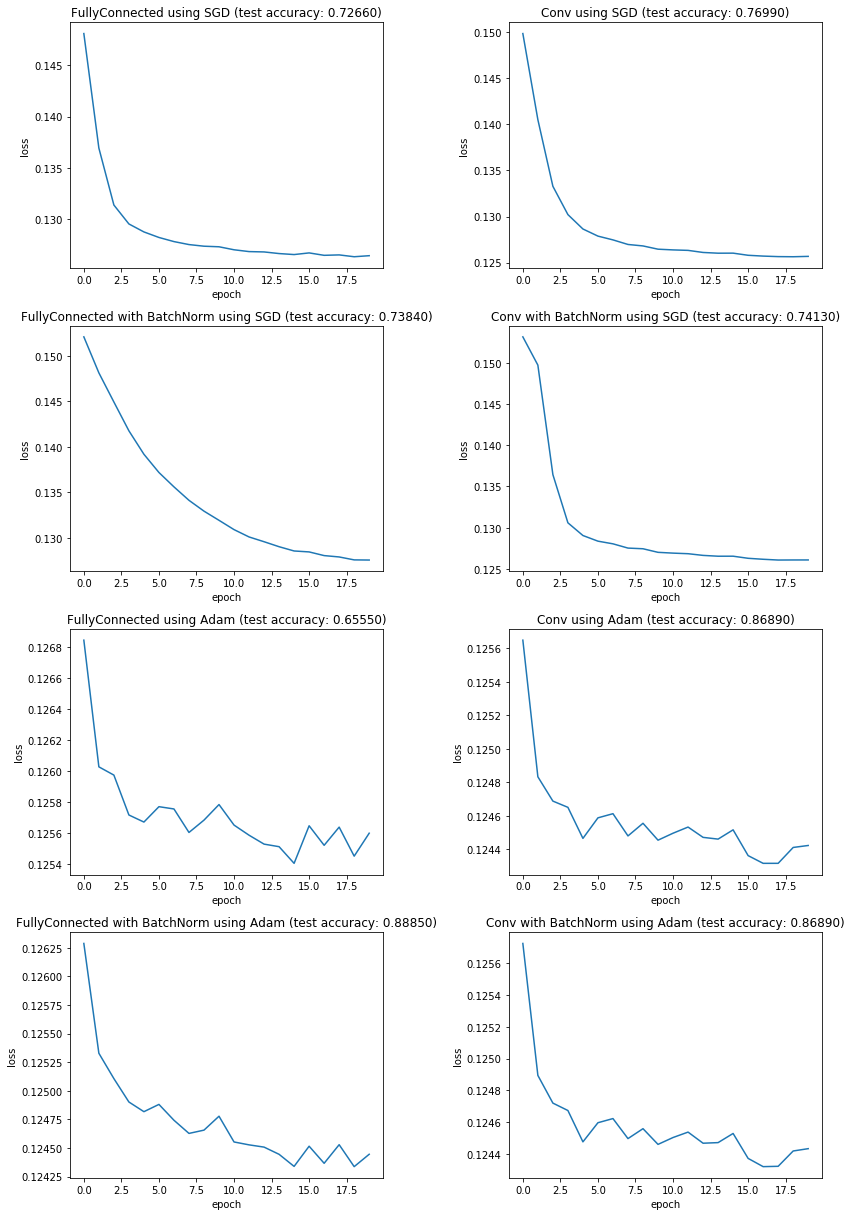

In [29]:
progress = FloatProgress(min=0, max=len(train_loader.dataset))
display(progress)

learn_rate = 0.001
num_epochs = 20

def xavier_weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight.data)
        m.bias.data.fill_(0)

_, axes = plt.subplots(4, 2, figsize=(12, 17))
axes = axes.flatten()
i = 0
for optim_type in ["SGD", "Adam"]:
    for do_batch_norm in [False, True]:
        for network_type in ["FullyConnected", "Conv"]:
            title = "{}{} using {}".format(network_type, " with BatchNorm" if do_batch_norm else "", optim_type)
            #print("-" * 50)
            #print("Training Network: {}".format(title))

            model = None
            if network_type == "FullyConnected":
                model = LinearNet(batch_norm=do_batch_norm, weight_init=xavier_weight_init)
            elif network_type == "Conv":
                model = ConvNet(batch_norm=do_batch_norm, weight_init=xavier_weight_init)

            optimizer = None
            if optim_type == "SGD":
                optimizer = optim.SGD(model.parameters(), lr=learn_rate)
            elif optim_type == "Adam":
                optimizer = optim.Adam(model.parameters(), lr=learn_rate)

            criterion = nn.CrossEntropyLoss()
            stats = train(num_epochs, optimizer, criterion, title.replace(" ", "_").lower())
            test_loss, num_correct, num_examples = test(model)

            #print("Test results\tAverage loss: {:.6f}\tAccuracy: {}/{} ({:.0f}%)".format(
            #    test_loss, num_correct, num_examples,
            #    100.0 * num_correct / num_examples)
            #)
            
            axes[i].set_title("{} (test accuracy: {:.5f})".format(title, num_correct / num_examples))
            axes[i].set_xlabel("epoch")
            axes[i].set_ylabel("loss")
            axes[i].plot(np.arange(num_epochs), stats["train"]["loss"])
            i+=1
            #print("")

plt.tight_layout()

Batch normalization reduces _internal covariate shift_. Internal covariate shift happens as features in different parts of the training data have different distributions than other parts. This violates the IID assumption, making training slower. To mitigate this, we normalize all the examples in a mini-batch with a zero-mean and scaled by its standard deviation, making the network learn faster.